In [1]:
import xarray as xr
import json
import gcsfs
import numpy as np

import matplotlib.pyplot as plt
import dask

In [3]:
from dask_gateway import Gateway
g = Gateway()
cluster = g.connect(g.list_clusters()[0].name)
client = cluster.get_client()

In [4]:
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.cff0a88c78734ed28102966c8f62a5b2/status,


In [5]:
with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

def open_ds(filepath=None):
    with dask.config.set(**{'array.slicing.split_large_chunks': True}):
        ds = xr.open_zarr(gcfs_w_token.get_mapper(f'pangeo-tmp/stb2145/ERA5/datasets/{filepath}surf_ds.zarr'))
    return ds

In [6]:
ds2022_winter = open_ds('2022_winter_')

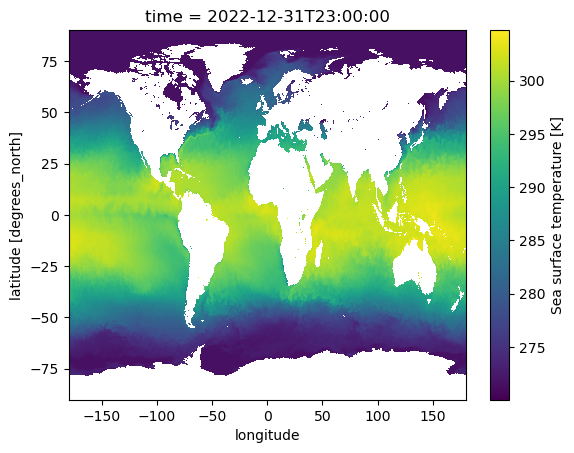

In [7]:
ds2022_winter.sst[-1].plot()

In [6]:
#add the last 3 months to each ds
ds2018 = xr.concat([open_ds('2018_'), open_ds('2018_winter_')], dim='time')
ds2019 = xr.concat([open_ds('2019_'), open_ds('2019_winter_')], dim='time')
ds2020 = xr.concat([open_ds('2020_'), open_ds('2020_winter_')], dim='time')
ds2021 = xr.concat([open_ds('2021_'), open_ds('2021_winter_')], dim='time')
ds2022 = xr.concat([open_ds('2022_'), open_ds('2022_winter_')], dim='time')
ds2023 = open_ds('')

/srv/conda/envs/notebook/lib/python3.10/site-packages/xarray/core/indexing.py:1443: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/srv/conda/envs/notebook/lib/python3.10/site-packages/xarray/core/indexing.py:1443: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/srv/conda/envs/no

In [7]:
ds2023_c = xr.concat([ds2023.isel(expver=0).sel(time=slice('2023-01', '2023-06')), 
                      ds2023.isel(expver=1).sel(time=slice('2023-07', '2023-09'))], dim='time')

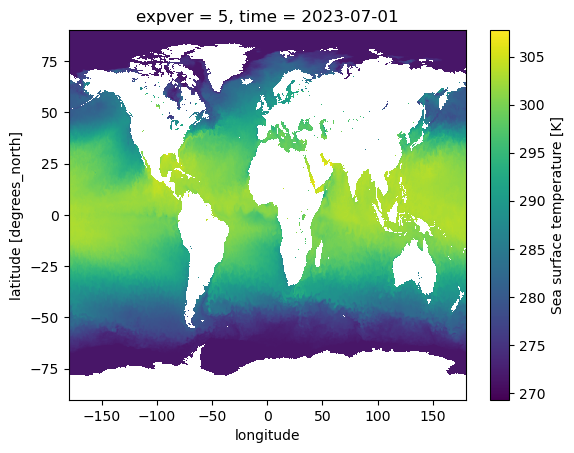

In [8]:
ds2023_c.sst.sel(time='2023-07-01', method='nearest').plot()

In [8]:
ds_unsorted = xr.concat([ds2018, ds2019, ds2020, ds2021, ds2022, ds2023_c.drop('expver')], dim='time')
with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ds = ds_unsorted.sortby(ds_unsorted.latitude)

In [9]:
ds

<xarray.Dataset>
Dimensions:    (time: 50309, latitude: 721, longitude: 1440)
Coordinates:
  * latitude   (latitude) float32 -90.0 -89.75 -89.5 -89.25 ... 89.5 89.75 90.0
  * longitude  (longitude) float32 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
  * time       (time) datetime64[ns] 2018-01-01 ... 2023-09-28T04:00:00
Data variables:
    e          (time, latitude, longitude) float32 dask.array<chunksize=(15, 721, 1440), meta=np.ndarray>
    ro         (time, latitude, longitude) float32 dask.array<chunksize=(15, 721, 1440), meta=np.ndarray>
    slhf       (time, latitude, longitude) float32 dask.array<chunksize=(15, 721, 1440), meta=np.ndarray>
    sro        (time, latitude, longitude) float32 dask.array<chunksize=(15, 721, 1440), meta=np.ndarray>
    sshf       (time, latitude, longitude) float32 dask.array<chunksize=(15, 721, 1440), meta=np.ndarray>
    ssr        (time, latitude, longitude) float32 dask.array<chunksize=(15, 721, 1440), meta=np.ndarray>
    ssrd       (time, latitude, longitude) float32 dask.array<chunksize=(15, 721, 1440), meta=np.ndarray>
    ssro       (time, latitude, longitude) float32 dask.array<chunksize=(15, 721, 1440), meta=np.ndarray>
    sst        (time, latitude, longitude) float32 dask.array<chunksize=(15, 721, 1440), meta=np.ndarray>
    str        (time, latitude, longitude) float32 dask.array<chunksize=(15, 721, 1440), meta=np.ndarray>
    strd       (time, latitude, longitude) float32 dask.array<chunksize=(15, 721, 1440), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2023-10-08 19:47:57 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

### Create mask object

In [10]:
hfacc = ds.sst.where(ds.sst == ds.sst.notnull(), 999).where(ds.sst < 999, np.nan)

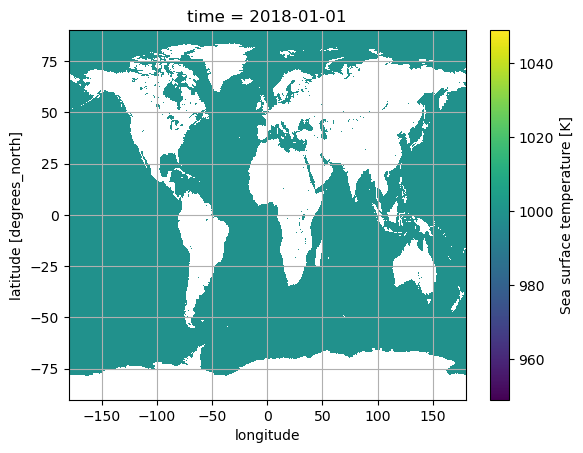

In [14]:
hfacc[0].plot()
plt.grid()

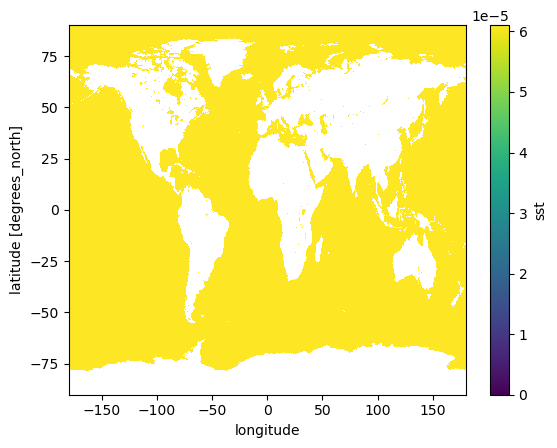

In [15]:
hfacc.std(dim='time').plot()

In [16]:
mask = hfacc[0]

In [17]:
mask

<xarray.DataArray 'sst' (latitude: 721, longitude: 1440)>
dask.array<getitem, shape=(721, 1440), dtype=float32, chunksize=(721, 1440), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 -90.0 -89.75 -89.5 -89.25 ... 89.5 89.75 90.0
  * longitude  (longitude) float32 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
    time       datetime64[ns] 2018-01-01
Attributes:
    long_name:  Sea surface temperature
    units:      K

## Focus in on Gulf region

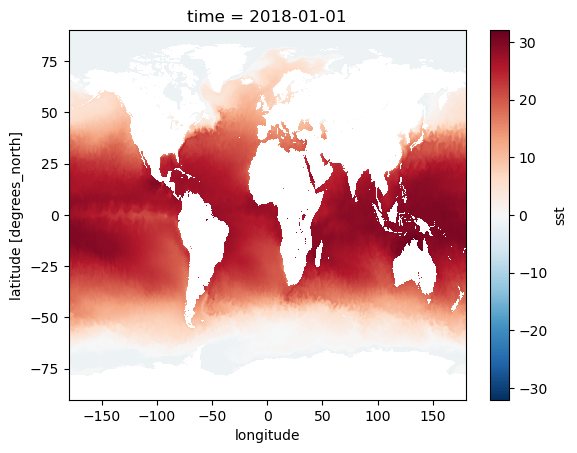

In [16]:
(ds.sst.isel(time=0) - 273.15).plot()

In [11]:
gulf = dict(longitude=slice(-100, 0), latitude=slice(8, 35))

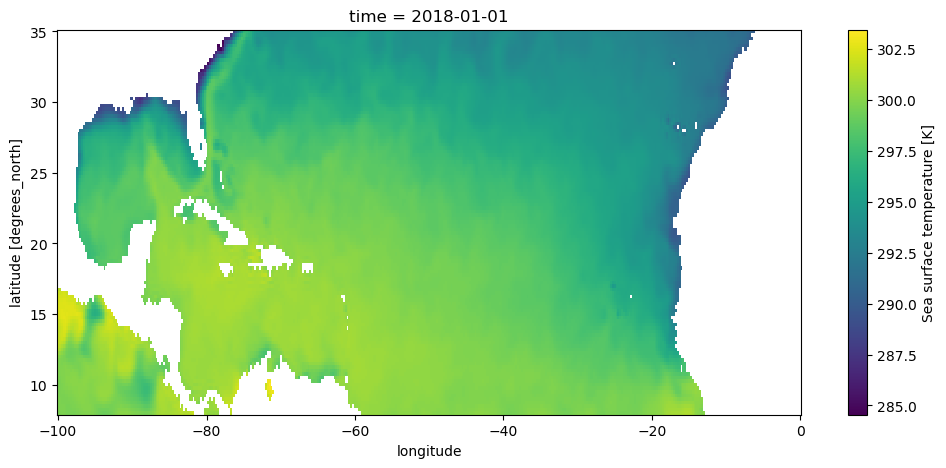

In [17]:
(ds.sst.isel(time=0).sel(**gulf)).plot(figsize=(12,5))

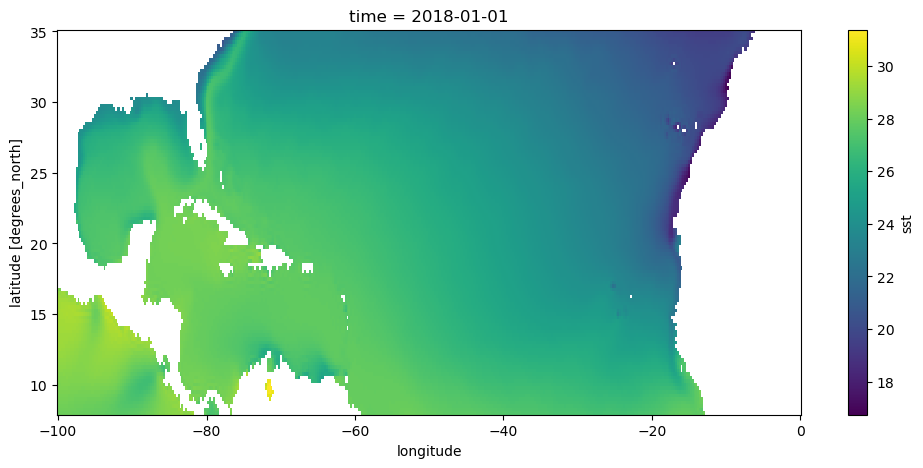

In [15]:
(ds.sst.sel(**gulf) - 273.15).mean('time').where(mask).plot(figsize=(12,5))

In [12]:
sst_trop = ds.sst.sel(**gulf) - 273.15

In [13]:
sst_trop

<xarray.DataArray 'sst' (time: 50309, latitude: 109, longitude: 401)>
dask.array<sub, shape=(50309, 109, 401), dtype=float32, chunksize=(15, 109, 401), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 8.0 8.25 8.5 8.75 ... 34.25 34.5 34.75 35.0
  * longitude  (longitude) float32 -100.0 -99.75 -99.5 -99.25 ... -0.5 -0.25 0.0
  * time       (time) datetime64[ns] 2018-01-01 ... 2023-09-28T04:00:00

In [14]:
import cmocean

Text(0.5, 1.0, 'Averaged 2018 - mid 2023 SST')

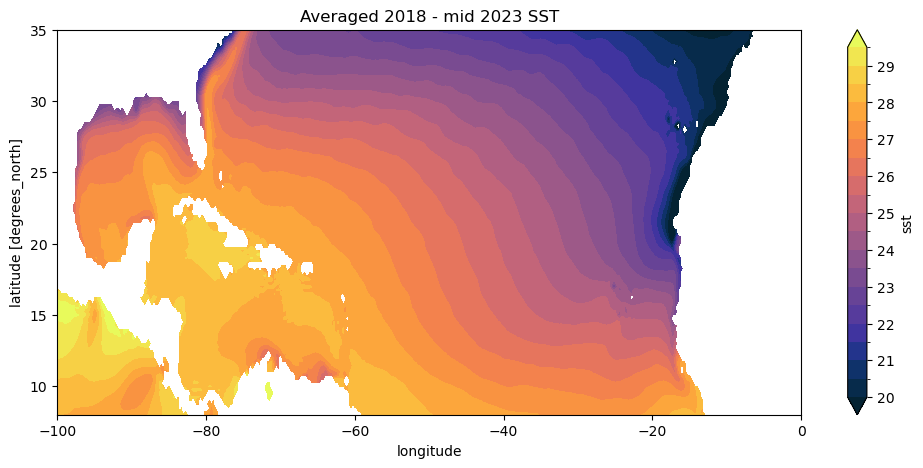

In [28]:
theta_levs = np.arange(20,30,0.5)

fig, ax = plt.subplots(figsize=(12,5))
C = sst_trop.where(mask).mean('time').where(mask).plot.contourf(colors=cmocean.cm.thermal, levels=theta_levs, 
                                                                ax=ax, add_colorbar=True)
plt.title('Averaged 2018 - mid 2023 SST')

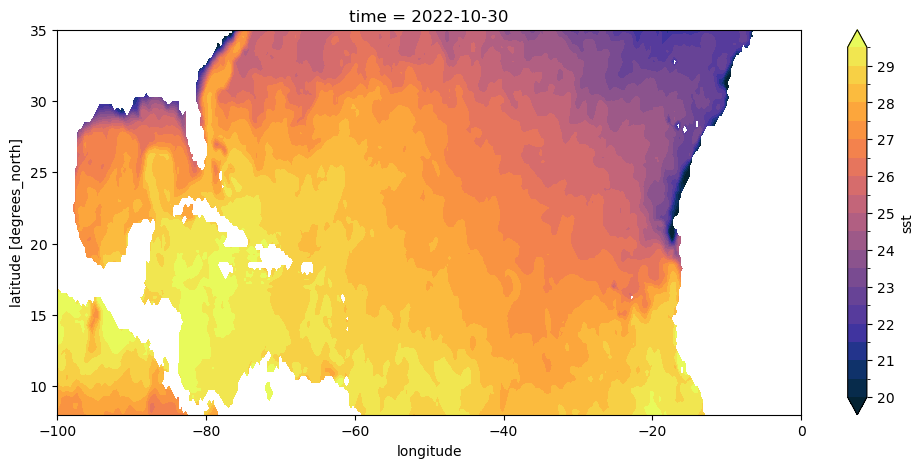

In [27]:
theta_levs = np.arange(20,30,0.5)

fig, ax = plt.subplots(figsize=(12,5))
C = sst_trop.where(mask).sel(time='2022-10-30', method='nearest').plot.contourf(colors=cmocean.cm.thermal, levels=theta_levs, 
                                                                ax=ax, add_colorbar=True)

## Fixed threshold

In [22]:
#daily clim
clim = sst_trop.groupby('time.dayofyear').mean('time')
clim_std = sst_trop.groupby('time.dayofyear').std('time')
anom = sst_trop.groupby('time.dayofyear') - clim

#monthly clim
mo_clim = sst_trop.groupby('time.month').mean('time')
mo_clim_std = sst_trop.groupby('time.month').std('time')
mo_anom = sst_trop.groupby('time.month') - mo_clim

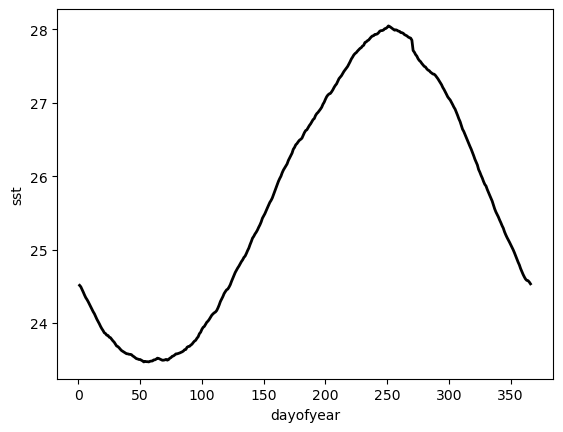

In [23]:
clim.mean(['latitude', 'longitude']).plot(color='k', linewidth=2)

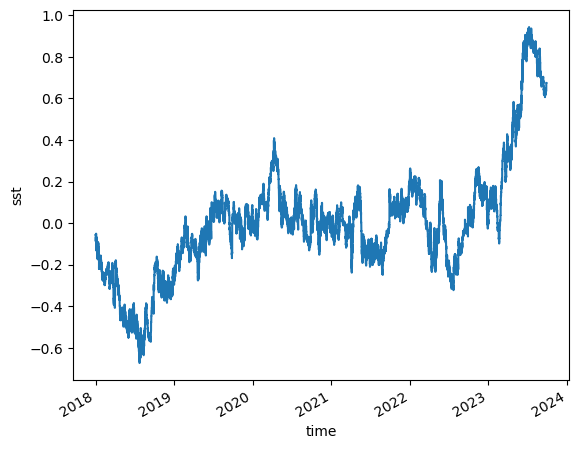

In [24]:
anom.mean(['latitude', 'longitude']).plot()

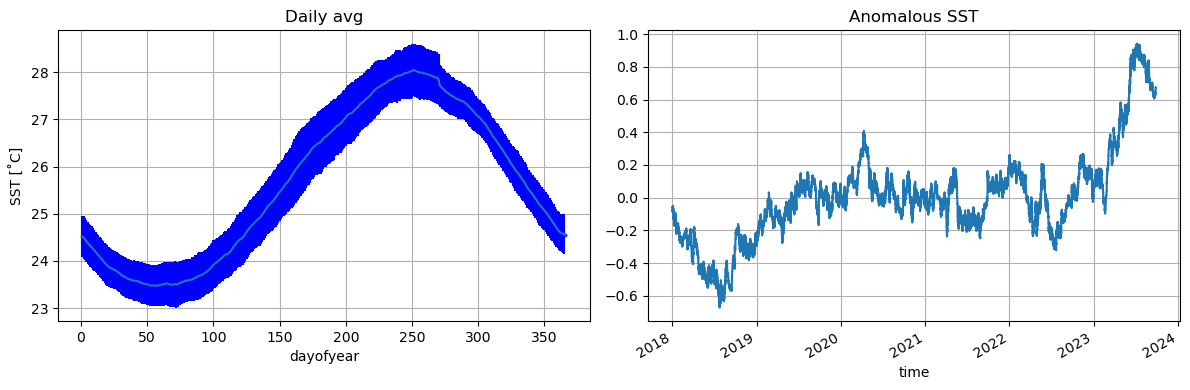

In [25]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(12,4))

clim.mean(['latitude', 'longitude']).plot(ax=ax0, color='k', linewidth=2)
ax0.errorbar(clim.mean(['latitude', 'longitude']).dayofyear, clim.mean(['latitude', 'longitude']), 
             yerr=clim_std.mean(['latitude', 'longitude']), ecolor='blue')
ax0.set_title('Daily avg')
anom.mean(['latitude', 'longitude']).plot(ax=ax1)
ax1.set_title('Anomalous SST')
ax0.set_ylabel('SST [˚C]')
ax1.set_ylabel('')

ax0.grid()
ax1.grid()
plt.tight_layout();

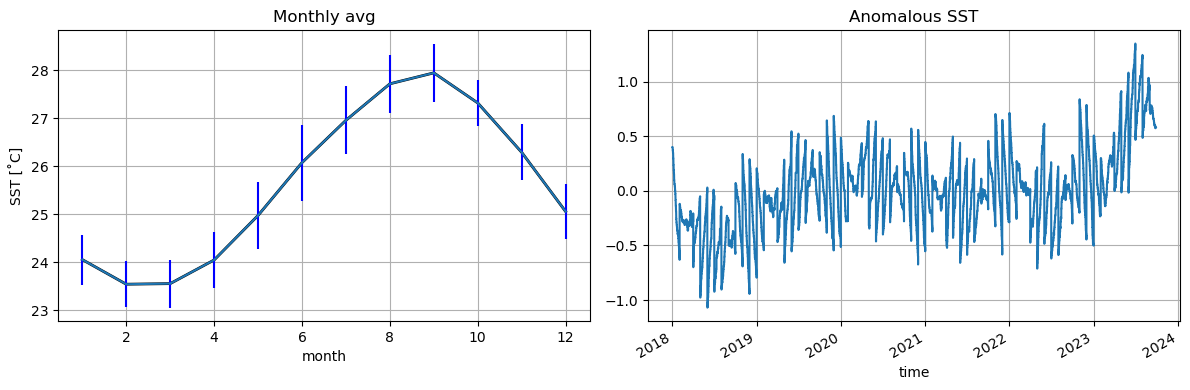

In [26]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(12,4))

mo_clim.mean(['latitude', 'longitude']).plot(ax=ax0, color='k', linewidth=2)
ax0.errorbar(mo_clim.mean(['latitude', 'longitude']).month, mo_clim.mean(['latitude', 'longitude']), 
             yerr=mo_clim_std.mean(['latitude', 'longitude']), ecolor='blue')
ax0.set_title('Monthly avg')
mo_anom.mean(['latitude', 'longitude']).plot(ax=ax1)
ax1.set_title('Anomalous SST')
ax0.set_ylabel('SST [˚C]')
ax1.set_ylabel('')

ax0.grid()
ax1.grid()
plt.tight_layout();

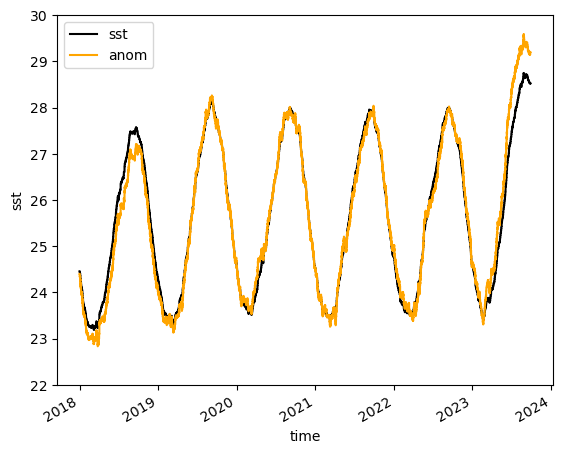

In [29]:
sst_trop.mean(['latitude', 'longitude']).plot(label='sst', color='k')
(sst_trop+anom).mean(['latitude', 'longitude']).plot(label='anom', color='orange')
plt.ylim(22,30)
plt.legend();

In [30]:
avg_sst_trop = sst_trop.mean(['latitude', 'longitude'])
avg_anom = (sst_trop+anom).mean(['latitude', 'longitude'])
hot = avg_anom.where(avg_anom > avg_sst_trop)
cold = avg_anom.where(avg_anom < avg_sst_trop)
hw = avg_anom.where(avg_anom > 27)
cs = avg_anom.where(avg_anom < 21)

In [31]:
hot

<xarray.DataArray 'sst' (time: 50309)>
dask.array<where, shape=(50309,), dtype=float32, chunksize=(15,), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 2018-01-01 ... 2023-09-28T04:00:00
    dayofyear  (time) int64 1 1 1 1 1 1 1 1 ... 270 270 270 271 271 271 271 271

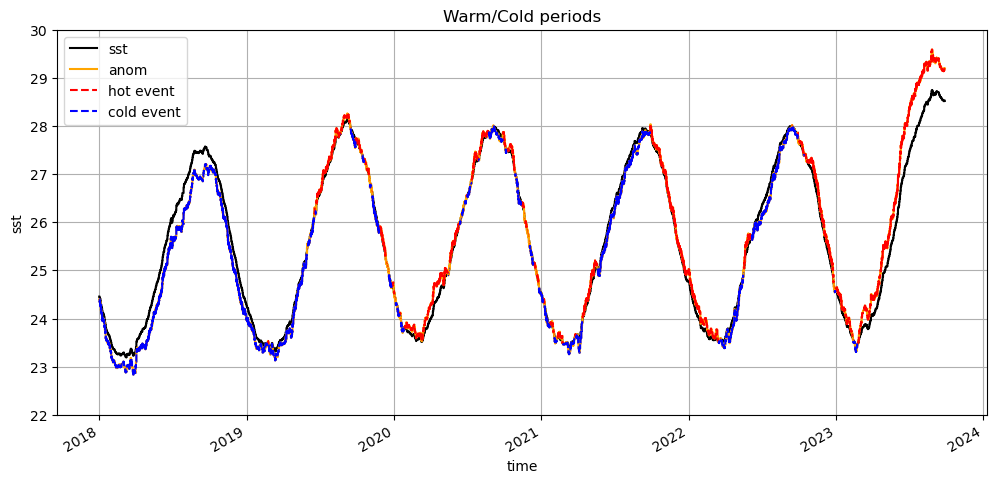

In [32]:
plt.figure(figsize=(12,5))

avg_sst_trop.plot(label='sst', color='k')
avg_anom.plot(label='anom', color='orange')
hot.plot(label='hot event', color='red', linestyle='dashed')
cold.plot(label='cold event', color='blue', linestyle='dashed')

plt.ylim(22,30)
plt.grid()
plt.legend()
plt.title('Warm/Cold periods');

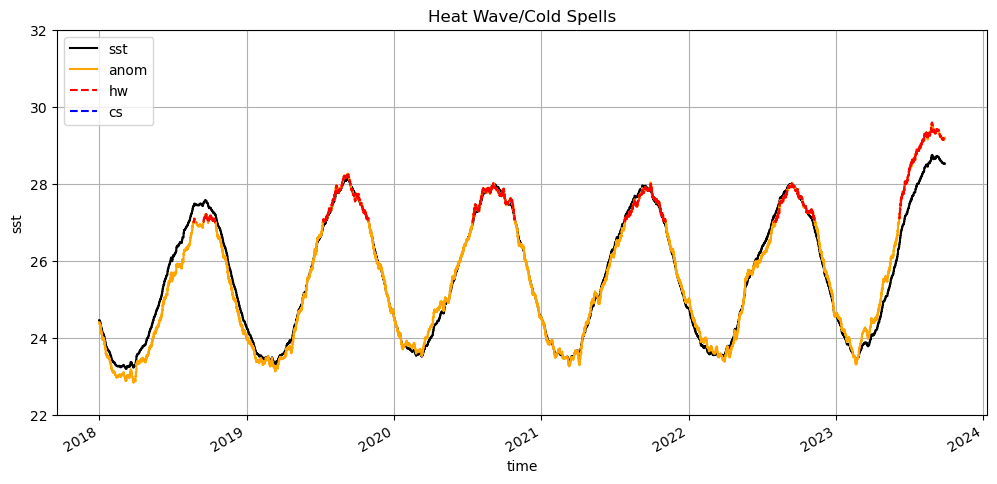

In [33]:
plt.figure(figsize=(12,5))

avg_sst_trop.plot(label='sst', color='k')
avg_anom.plot(label='anom', color='orange')
hw.plot(label='hw', color='red', linestyle='dashed')
cs.plot(label='cs', color='blue', linestyle='dashed')

plt.ylim(22,32)
plt.grid()
plt.legend()
plt.title('Heat Wave/Cold Spells');

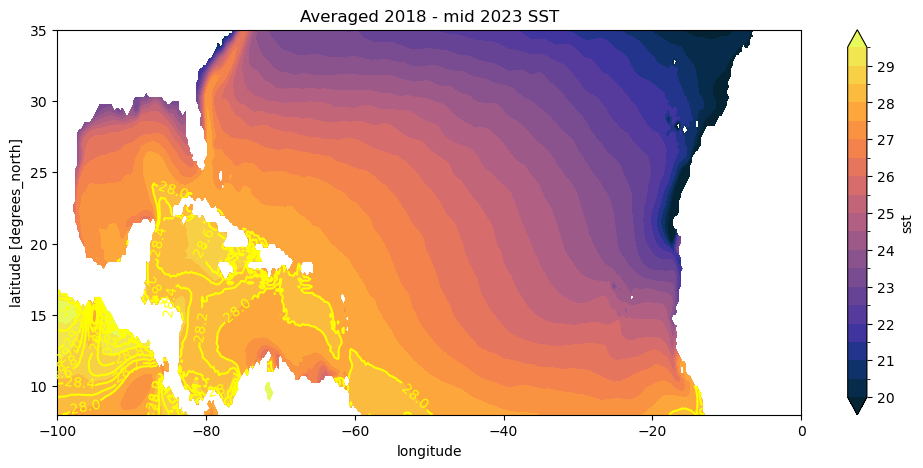

In [34]:
theta_levs = np.arange(20,30,0.5)

fig, ax = plt.subplots(figsize=(12,5))

C = sst_trop.mean('time').plot.contour(colors='yellow', levels=np.arange(28, 30, 0.2), ax=ax)
plt.clabel(C)

Cf = sst_trop.where(mask).mean('time').where(mask).plot.contourf(colors=cmocean.cm.thermal, levels=theta_levs, 
                                                                ax=ax, add_colorbar=True)
plt.title('Averaged 2018 - mid 2023 SST');

# Movie

In [16]:
upload_sst = sst_trop.chunk({'time':45})
upload_sst

<xarray.DataArray 'sst' (time: 50309, latitude: 109, longitude: 401)>
dask.array<rechunk-merge, shape=(50309, 109, 401), dtype=float32, chunksize=(45, 109, 401), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 8.0 8.25 8.5 8.75 ... 34.25 34.5 34.75 35.0
  * longitude  (longitude) float32 -100.0 -99.75 -99.5 -99.25 ... -0.5 -0.25 0.0
  * time       (time) datetime64[ns] 2018-01-01 ... 2023-09-28T04:00:00

In [2]:
import json
import gcsfs

with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

ds_sst = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/ERA5/datasets/sst_trop_ds.zarr'))

In [3]:
ds_sst.sst

<xarray.DataArray 'sst' (time: 50309, latitude: 109, longitude: 401)>
dask.array<open_dataset-sst, shape=(50309, 109, 401), dtype=float32, chunksize=(45, 109, 401), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 8.0 8.25 8.5 8.75 ... 34.25 34.5 34.75 35.0
  * longitude  (longitude) float32 -100.0 -99.75 -99.5 -99.25 ... -0.5 -0.25 0.0
  * time       (time) datetime64[ns] 2018-01-01 ... 2023-09-28T04:00:00

In [4]:
resampled = ds_sst.sst.resample(time='D').mean()

In [5]:
resampled

<xarray.DataArray 'sst' (time: 2097, latitude: 109, longitude: 401)>
dask.array<transpose, shape=(2097, 109, 401), dtype=float32, chunksize=(3, 109, 401), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 8.0 8.25 8.5 8.75 ... 34.25 34.5 34.75 35.0
  * longitude  (longitude) float32 -100.0 -99.75 -99.5 -99.25 ... -0.5 -0.25 0.0
  * time       (time) datetime64[ns] 2018-01-01 2018-01-02 ... 2023-09-28

In [6]:
loaded_sst = resampled.compute()

In [7]:
loaded_sst

<xarray.DataArray 'sst' (time: 2097, latitude: 109, longitude: 401)>
array([[[26.536535, 26.544924, 26.564497, ...,       nan,       nan,
               nan],
        [26.550262, 26.55124 , 26.561903, ...,       nan,       nan,
               nan],
        [26.56682 , 26.557604, 26.56334 , ...,       nan,       nan,
               nan],
        ...,
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]],

       [[26.620056, 26.62194 , 26.636337, ...,       nan,       nan,
               nan],
        [26.64055 , 26.632004, 26.632067, ...,       nan,       nan,
               nan],
        [26.65888 , 26.635141, 26.626379, ...,       nan,       nan,
               nan],
...
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]],

       [[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        ...,
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]]], dtype=float32)
Coordinates:
  * latitude   (latitude) float32 8.0 8.25 8.5 8.75 ... 34.25 34.5 34.75 35.0
  * longitude  (longitude) float32 -100.0 -99.75 -99.5 -99.25 ... -0.5 -0.25 0.0
  * time       (time) datetime64[ns] 2018-01-01 2018-01-02 ... 2023-09-28

In [9]:
from xmovie import Movie
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [10]:
import cmocean

def contour_surf(da, fig, tt, *args, **kwargs):
    
    ax = fig.subplots()
    theta_levs = np.arange(20,32,0.5)

    C = loaded_sst.isel(time=tt).plot.contour(colors='yellow', levels=[29], ax=ax)
    #ax.clabel(C)
    
    Cf = da.isel(time=tt).plot.contourf(colors=cmocean.cm.thermal, levels=theta_levs, 
                                                                ax=ax, add_colorbar=True)
    
    return ax, Cf

(<Axes: title={'center': 'time = 2018-01-01'}, xlabel='longitude', ylabel='latitude [degrees_north]'>,
 <matplotlib.contour.QuadContourSet at 0x7fd3be41b790>)

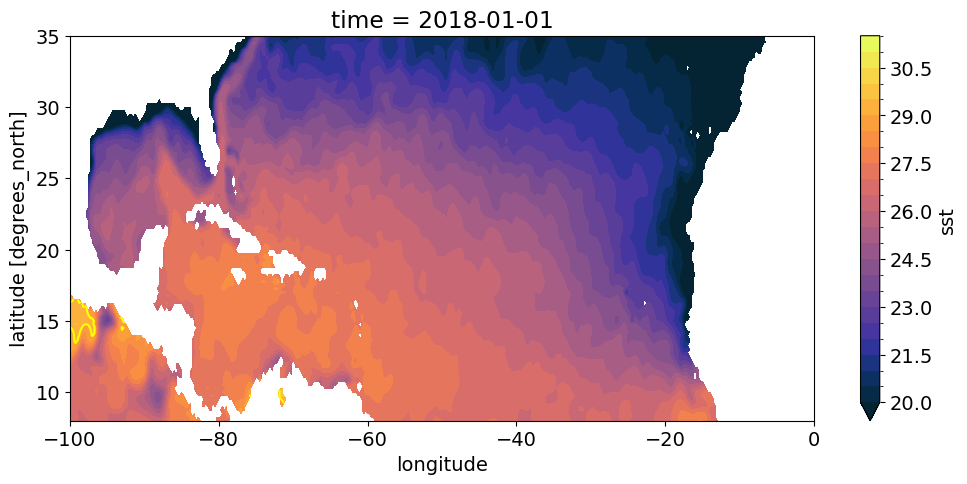

In [11]:
fig = plt.figure(figsize=(12, 5))

contour_surf(loaded_sst, fig, 0)

In [12]:
sst = Movie(loaded_sst, contour_surf, 
                   input_check=False)

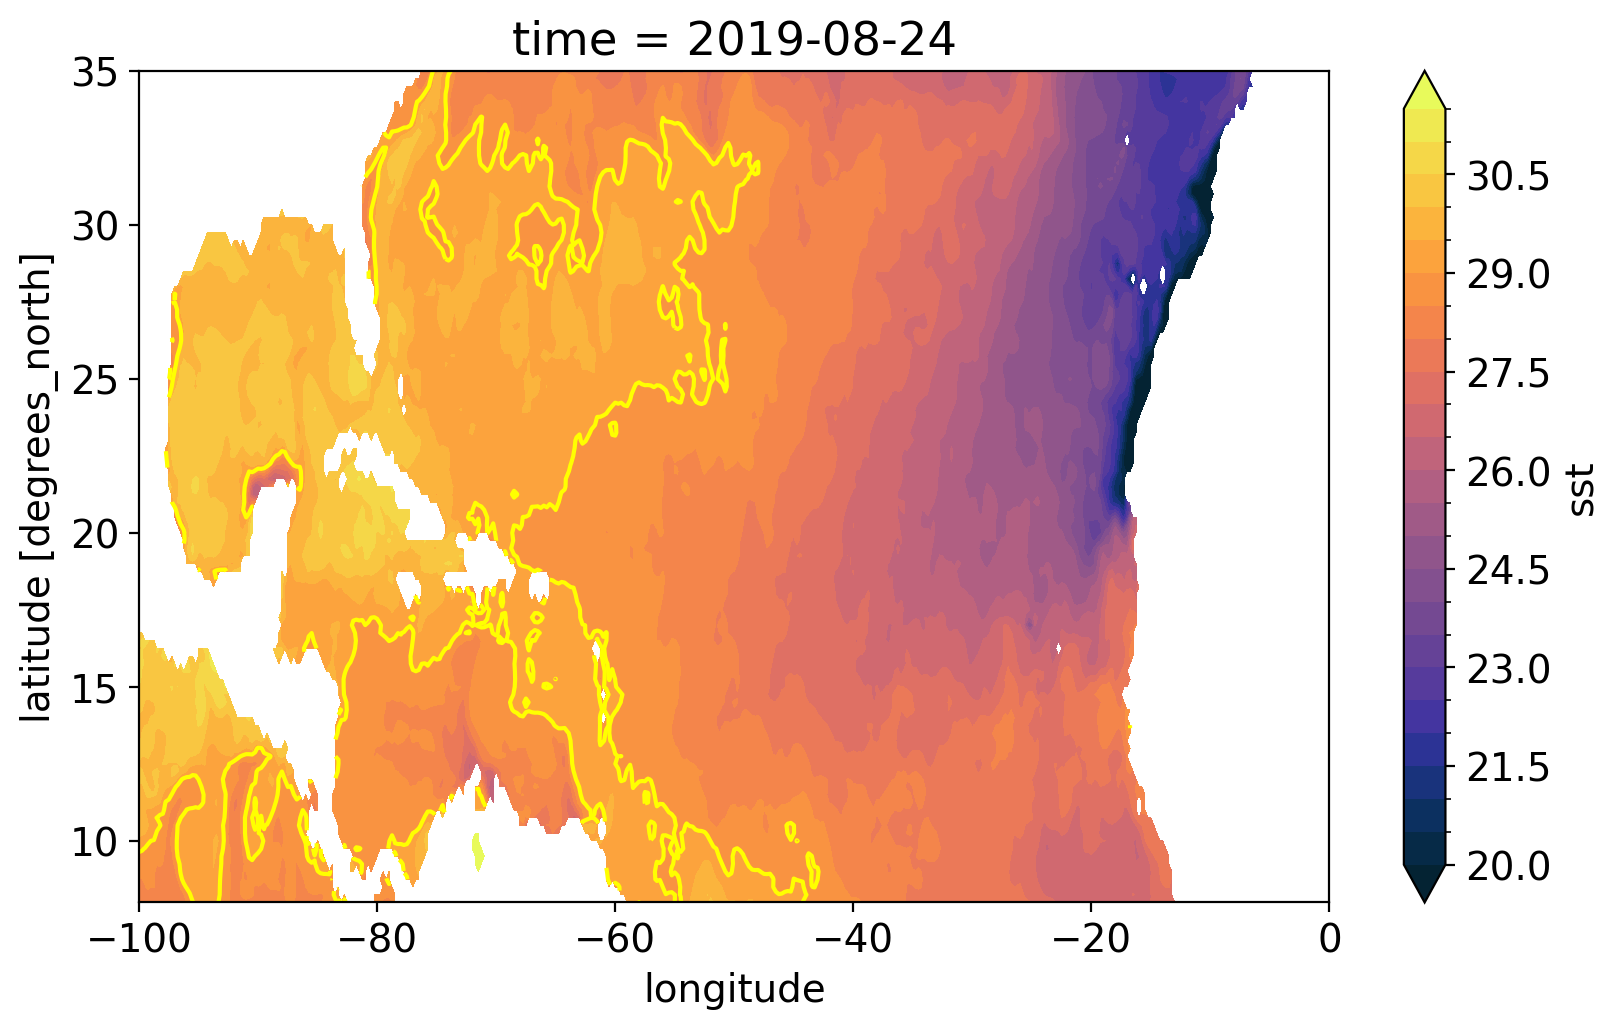

In [14]:
sst.preview(600)

In [15]:
#save sstmovie
sst.save('sst_daily.mp4', progress=True, overwrite_existing=True)

  0%|          | 0/2097 [00:00<?, ?it/s]

Movie created at sst_daily.mp4
